<a href="https://colab.research.google.com/github/callor/Callor-DeepLearning-2022/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 삼성전자 주가 예측 

* 데이터출처 : https://finance.yahoo.com/quote/005930.KS/history?period1=1641009600&period2=1671076799&interval=1d&frequency=1d&filter=history

* 주가를 인공지능으로 예측한다는 것은 현실적으로 불가능에 가깝다라는 어느 경제 학자의 오래된 이야기가 생각난다. 
* 하지만, 데이터를 이용한 딥러닝 학습에 이만한 예제가 있을까 생각된다.
* 삼성전자의 2012년 1월 부터 2012년 12월 14일까지의 데이터를 `야후 파이넨셜` 에서 다운로드 받아 `LSTM` 알고리즘을 통한 주가 예측 딥러닝 모델링을 작성한다
* `파이토치(Pytorch)`를 사용한 LSTM 관련 문서를 참조하여 작성하였다.  
원본 출처 : https://cnvrg.io/pytorch-lstm/?gclid=Cj0KCQiA6t6ABhDMARIsAONIYyxsIXn6G6EcMLhGnPDxnsKiv3zLU49TRMxsyTPXZmOV3E-Hh4xeI2EaAugLEALw_wcB

In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (18.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt



import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [68]:
# 한글깨짐 방지지
plt.rc('font', family='NanumBarunGothic') 

In [31]:
start = (2012, 1, 1)  # 2012년 01년 01월 ~
start = datetime.datetime(*start)  
end = datetime.date.today()  # 현재 

# yahoo 에서 삼성 전자 불러오기 
# df = pdr.DataReader('005930.KS', 'yahoo', start, end)
# 야후에서 자동 다운로드가 되지 않는다
# Console 링크를 따라가서 csv 파일을 다운로드 받는다다
# https://finance.yahoo.com/quote/005930.KS/history?period1=1641009600&period2=1671076799&interval=1d&frequency=1d&filter=history

# df = pd.read_csv('005930(2012-01-01).KS.csv')

# 날짜 칼럼을 index 로 하여 데이터 만들기
df = pd.read_csv('005930(2012-01-01).KS.csv', index_col = 'Date', parse_dates=True)

"""
# 불러온 데이터에 유효하지 않은 값이 있는지 확인
각 column 의 count 값을 확인하여 count 값이 다른 칼럼보다
작으면 해당 칼럼에 NaN 데이터가 존재한다는 것을 알 수 있다.

테이블에서는 count 뿐만 아니라, 
mean / std와 같은 속성들에 대한 종합적인 정보도 제공해 줍니다.
"""
print(df.describe())

"""
.info()의 메소드를 활용해서도 NaN값이 어느 column에서 빠졌는지 쉽게 확인할 수 있다.
"""
print(df.info())


               Open          High           Low         Close     Adj Close  \
count   2695.000000   2695.000000   2695.000000   2695.000000   2695.000000   
mean   43057.395176  43461.243043  42644.478664  43045.703154  38652.386014   
std    17902.852552  18046.177797  17752.803949  17880.147465  18804.722204   
min    20320.000000  20480.000000  20220.000000  20320.000000  16251.537110   
25%    26770.000000  26960.000000  26490.000000  26740.000000  21786.947270   
50%    41950.000000  42440.000000  41700.000000  42140.000000  37181.941410   
75%    54400.000000  54850.000000  53800.000000  54250.000000  49188.619140   
max    90300.000000  96800.000000  89500.000000  91000.000000  87764.796880   

             Volume  
count  2.695000e+03  
mean   1.410899e+07  
std    7.224147e+06  
min    0.000000e+00  
25%    9.591050e+06  
50%    1.244584e+07  
75%    1.649126e+07  
max    9.030618e+07  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2695 entries, 2012-01-02 to 2022-12-1

In [27]:
# df.head(5)
# 끝에서 5개의 데이터 보여주기
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-01,63100,63200,62300,62600,62600.0,16631445
2022-12-02,62500,62500,60400,60400,60400.0,15331184
2022-12-05,60900,61100,60000,60300,60300.0,13767787
2022-12-06,59800,60100,59200,59200,59200.0,13888300
2022-12-07,58800,59600,58500,58900,58900.0,12100662
2022-12-08,58700,59200,58600,59200,59200.0,12986815
2022-12-09,59300,60600,59300,60400,60400.0,10529632
2022-12-12,59900,60000,59400,59500,59500.0,9036472
2022-12-13,59600,60300,59400,59700,59700.0,9040873


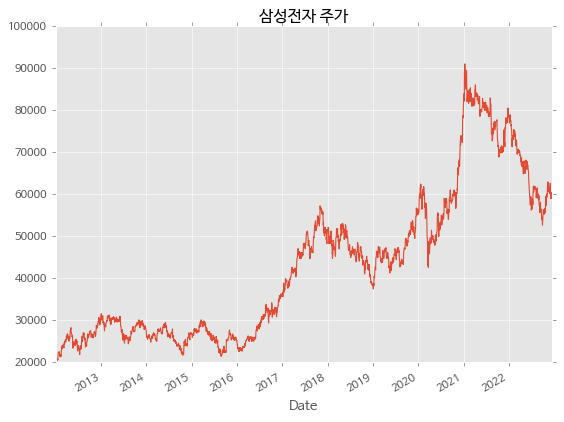

In [32]:
plt.style.use('ggplot')
# 종가 기준으로 그래프 그리기
df['Close'].plot(label='종가', title='삼성전자 주가')

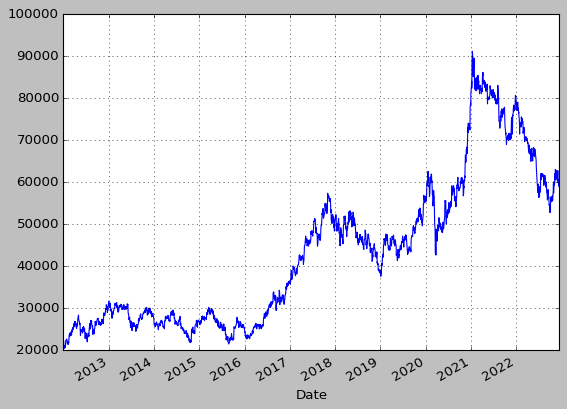

In [36]:
# 종가 기준으로 그래프 그리기
plt.style.use('classic')
df.Close.plot(grid=True)

In [45]:
"""
파일에 있는 데이터의 각 항목은 다음과 같다
open 시가
high 고가
low 저가
close 종가
volume 거래량
Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

여기에서 거래량(Volume)은 데이터에서 삭제를 하고,
X 값으로는 Volume 이 제거된 데이터를 담고
y 값으로 Adj Close(종가)를 담는다.
"""
# X = df.drop(columns='Volume')
# y = df.iloc[:, 5:6]

X = df.iloc[:, :-2]

# 날짜와 종가데이터만 추출
y = df.iloc[:, 3:4] 

print(X)
print(y)

             Open   High    Low  Close
Date                                  
2012-01-02  21400  21600  21300  21600
2012-01-03  21860  22100  21840  22100
2012-01-04  22100  22200  21500  21600
2012-01-05  21460  21580  21100  21100
2012-01-06  21120  21320  20600  20800
...           ...    ...    ...    ...
2022-12-08  58700  59200  58600  59200
2022-12-09  59300  60600  59300  60400
2022-12-12  59900  60000  59400  59500
2022-12-13  59600  60300  59400  59700
2022-12-14  59800  60600  59800  60300

[2695 rows x 4 columns]
            Close
Date             
2012-01-02  21600
2012-01-03  22100
2012-01-04  21600
2012-01-05  21100
2012-01-06  20800
...           ...
2022-12-08  59200
2022-12-09  60400
2022-12-12  59500
2022-12-13  59700
2022-12-14  60300

[2695 rows x 1 columns]


In [94]:
"""
학습이 잘되기 위해 데이터를 정규화 한다.
StandardScaler : 각 특징의 평균을 0, 분산을 1이 되도록 변경한다
MinMaxScaler : 최대/최소값이 각각 1, 0이 되도록 변경
"""
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

# 이렇게 하면 데이터 세트가 변환되고 크기가 조정됩니다.
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# 학습데이터 추출
"""
다음은 데이터 세트를 두 부분으로 나눈다.
1은 교육용이고 다른 부분은 값을 테스트하기 위한 것이다. 
순차 데이터이고 순서가 중요하므로 처음 2200(약 80%)개 행을 학습용으로, 
나머지 행을 데이터 테스트용으로 사용한다. 
"""
X_train = X_ss[:2500, :]
X_test = X_ss[2500:, :]

# 테스트(예측)용 데이터 추출
"""
( 굳이 없어도 된다. 하지만 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해 
from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. )
"""
y_train = y_mm[:2500, :]
y_test = y_mm[2500:, :] 

# 확인을 위해 교육 및 테스트 데이터 셰이프를 인쇄
print("Training Shape", X_train.shape , y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2500, 4) (2500, 1)
Testing Shape (195, 4) (195, 1)


In [95]:
"""
PyTorch에서 프로그래밍하는 경우 PyTorch에서 다루는 모든 것은 
numpy의 강력한 버전으로 생각할 수 있는 텐서라는 것을 알아야 한다.
따라서 데이터 세트를 텐서로 변환해야 한다
"""
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

"""
이제 다음 단계는 LSTM의 입력 형식을 확인하는 것이다.
즉, LSTM은 순차 데이터용으로 특별히 제작되었기 때문에 
단순한 2차원 데이터를 입력으로 사용할 수 없다. 
우리가 각 타임스탬프에 입력이 필요하다고 논의한 것처럼 
그들도 타임스탬프 정보를 가지고 있어야 한다. 
데이터 세트를 변환해 보자
"""

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([2500, 1, 4]) torch.Size([2500, 1])
Testing Shape torch.Size([195, 1, 4]) torch.Size([195, 1])


In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
# print(torch.cuda.get_device_name(0))

In [108]:
"""
이제 학습할 준비가 되었다. 
이제 LSTM 모델을 만들 차례이다. 
PyTorch는 훨씬 더 파이썬적이기 때문에 PyTorch의 모든 모델은 
nn.Module 슈퍼클래스에서 상속되어야 한다.


여기에서 모든 중요한 변수와 레이어를 정의한다. 
다음으로 (hidden_size를 통해) 서로 겹쳐진 동일한 하이퍼파라미터가 있는 
2개의 LSTM 레이어를 사용하고, 
2개의 완전 연결 레이어, ReLU 레이어 및 일부 도우미 변수를 정의한다.
다음으로 LSTM의 순방향 패스를 정의한다.

"""
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 



여기에서 숨겨진 상태와 내부 상태를 먼저 정의하고 0으로 초기화했다.
우선 현재 타임스탬프 t의 입력과 함께 숨겨진 상태와 내부 상태를 LSTM에 전달할 것이다.
그러면 새로운 숨겨진 상태, 현재 상태 및 출력이 반환된다 
출력이 Dense Layer로 전달될 수 있도록 모양을 변경한다. 
다음으로 간단히 활성화를 적용하고 고밀도 레이어에 전달한 다음 출력을 반환한다.   

이것은 Forward Pass와 LSTM1 클래스를 완성한다. 
런타임 시 모델을 교육하는 동안 backpropagation logic을 적용한다

In [121]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 4 #number of features
hidden_size = 5 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [122]:
# 위에서 선언한 LSTM 클래스를  사용하여 객체 생성
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) 

# mean-squared error for regression
criterion = torch.nn.MSELoss()    

optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

print(num_epochs)
print(criterion)
print(optimizer)


1000
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [53]:
print(X_train_tensors_final)

tensor([[[-1.2099, -1.2116, -1.2025, -1.1996]],

        [[-1.1842, -1.1839, -1.1721, -1.1717]],

        [[-1.1708, -1.1784, -1.1913, -1.1996]],

        ...,

        [[ 1.6393,  1.6649,  1.6482,  1.6700]],

        [[ 1.6281,  1.6316,  1.6313,  1.6029]],

        [[ 1.6225,  1.6870,  1.6539,  1.7259]]])


In [123]:
# 학습하기
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.08527
Epoch: 100, loss: 0.00282
Epoch: 200, loss: 0.00069
Epoch: 300, loss: 0.00011
Epoch: 400, loss: 0.00005
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00002


In [124]:
"""
손실이 적고 성능이 좋다는 것을 알 수 있습니다. 데이터 세트에 대한 예측을 플로팅하여 성능을 확인하겠습니다.
"""

df_X_ss = ss.transform(df.iloc[:, :-2]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -3:-2]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


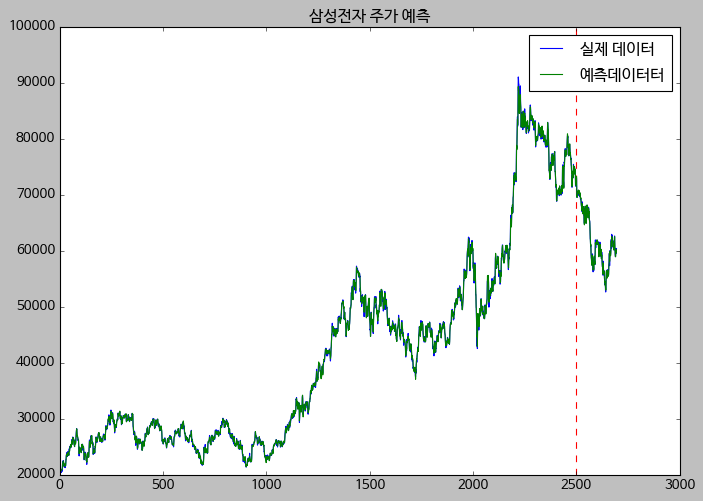

In [125]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,7)) #plotting
plt.axvline(x=2500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='실제 데이터') #actual plot
plt.plot(data_predict, label='예측데이터터') #predicted plot
plt.title('삼성전자 주가 예측')
plt.legend()
plt.show() 
# 더 작은 데이터 세트를 사용함에도 불구하고 모델이 꽤 잘 수행되고 있음을 알 수 있습니다